In [13]:
import cv2
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
from scipy import interpolate

from numba import njit

baseline = 0.05
dt = 0.01
time_x = np.arange(0, 25, dt)

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial'

savefolder = "/Users/your/savefolder"
datafolder = "/Users/your/datafolder"

(33648, 12)
(13861, 11)


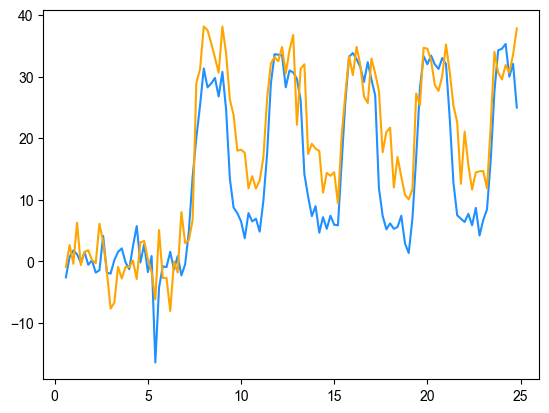

In [15]:
## import the real data of average angle (in blue (zebrafish) and orange (medaka))


import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os

from scipy.optimize import curve_fit


exp_names = ["zebra_stimRest", "medaka_stimRest"]
species = ["zebrafish", "medaka"]
colors = ["dodgerblue", "orange"]
datas = [pd.read_pickle(r"%s/df_zebra_0dph_group_black_stimRest_pulse.pkl" % datafolder),
         pd.read_pickle(r"%s/df_medaka_0dph_group_black_stimRest_pulse.pkl" % datafolder)]

ave_angles_species = []
ave_times_species = []

for exp_name_i, exp_name in enumerate(exp_names):
    color = colors[exp_name_i]
    data = datas[exp_name_i]
    
    good_fishs = []
    ## screen fish who responds to open-loop converging stimuli
    for fish_i in range(62):
        if (exp_name_i == 0) & (fish_i == 31):
            pass
        elif (exp_name_i == 0) & (fish_i == 38):
            pass
        else:
            fish_data = data.loc[(data['fish_index'] == fish_i)]

            if fish_data['center_distance'].mean() < 30:
                good_fishs.append(fish_i)
            
    selected_fish_data = data.loc[data['fish_index'].isin(good_fishs)]

    patterns_good = [7] ## this is when the stimuli is 2 sec pulse, 2 sec rest
    ave_angles = []
    ave_times = []
    show_unit_x = np.arange(0.5, 25, 0.2)
        
    for pattern in patterns_good:
            
        stimulus_pattern_n = pattern
        r_stim_data = selected_fish_data.loc[(selected_fish_data['stimulus_index'] == stimulus_pattern_n)]

        stimulus_pattern_n = pattern + len(patterns)
        l_stim_data = selected_fish_data.loc[(selected_fish_data['stimulus_index'] == stimulus_pattern_n)]

        df = r_stim_data.copy()
        df['bout_angle'] = r_stim_data['bout_angle'] * (-1)

        merge_data = [l_stim_data, df]
        big_data = pd.concat(merge_data)
        print(np.shape(big_data))
            
        for t_unit in range(len(show_unit_x)-1):
            
            unit_data = big_data.loc[(big_data['start_time_index'] > show_unit_x[t_unit]) & (big_data['start_time_index'] <= show_unit_x[t_unit+1])]
            ave_unit = np.nanmean(unit_data['bout_angle'])
            ave_angles.append(ave_unit)
            ave_times.append((show_unit_x[t_unit] + show_unit_x[t_unit+1])/2)
            
    ave_angles_species.append(ave_angles)
    ave_times_species.append(ave_times)

for exp_name_i, exp_name in enumerate(exp_names):
    plt.plot(ave_times_species[exp_name_i], ave_angles_species[exp_name_i], color=colors[exp_name_i])
                
     

0.14838929636891746 0.07973842448478854
0.1897107447936802 4.1674645727242286e-20
0.4461794232153535 0.000758528130778092
0.6242315588400257 0.011381006924370897
0.6949170542563663 0.01843928292323055
0.6712257964347398 0.04375360753152352
0.6079893514440695 0.037747761204338384
0.5769107917869071 0.03703009158418383
0.6076073588034628 0.031213562621174053
0.5830131590257468 0.02609810418102871
0.5849527020483241 0.03739234374235437
0.35687487393407724 0.024643752464843214
0.22033157818874397 0.022479180205960195
0.1650746515378099 0.046766982631106846
0.12855301521395693 0.04144187090509907
0.12048871327277855 0.01700646788929868
0.11666161048529973 0.04383486445971921
0.1566807993621094 0.035516563874954325
0.1314042532306405 0.0342884072458057


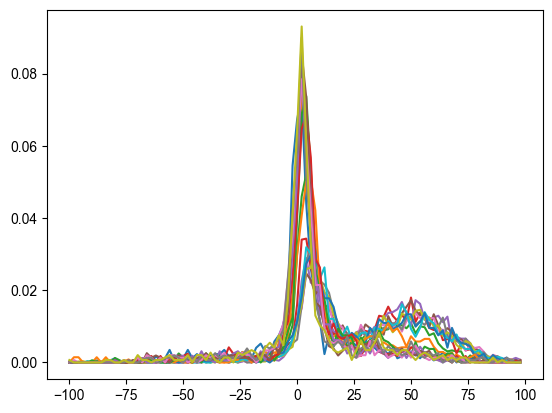

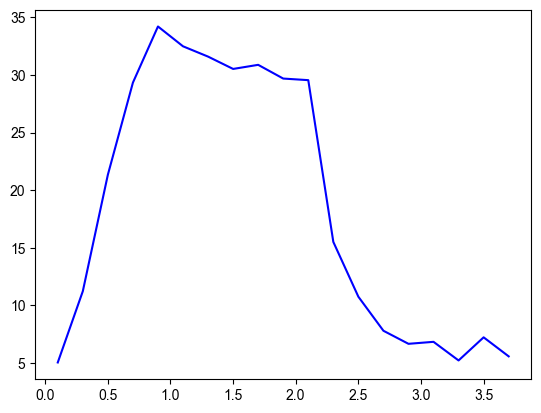

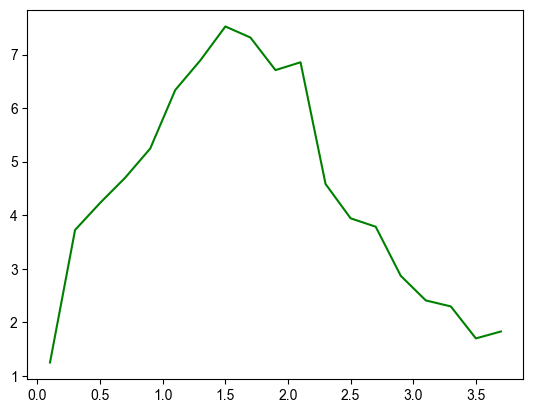

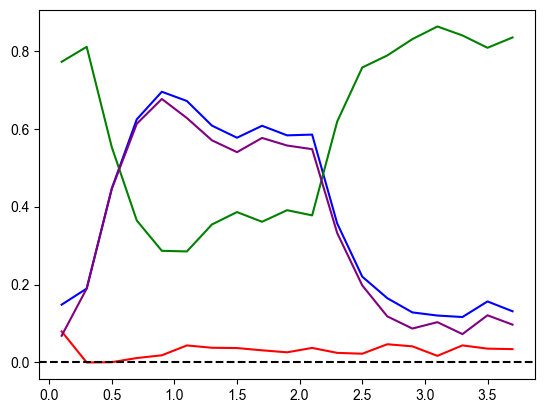

0.11046118473773213 0.013742435623138786
0.2092194405228106 0.038100543246370334
0.39281445231245626 0.024083232116211502
0.5571766744089599 0.04966371500089027
0.6225750992185334 0.04390059275469926
0.6060177793446081 0.047275885890833744
0.5137335704491063 0.04154406205236694
0.4900176292908894 0.06555863087782487
0.500502081901951 0.052147107977044325
0.5386301322156413 0.05505278691135085
0.49668279948921457 0.03907859861963274
0.46016790134741486 0.017534526660023017
0.3210082551947879 0.02108305081721609
0.16473862557240887 0.050460747354208704
0.20602834552721885 0.01785809888354961
0.1708108393671335 0.010549914859447253
0.1469492532923424 0.0012427332603937343
0.16328924976942996 0.0028760484469828517
0.12084469913568827 0.02486191078857671


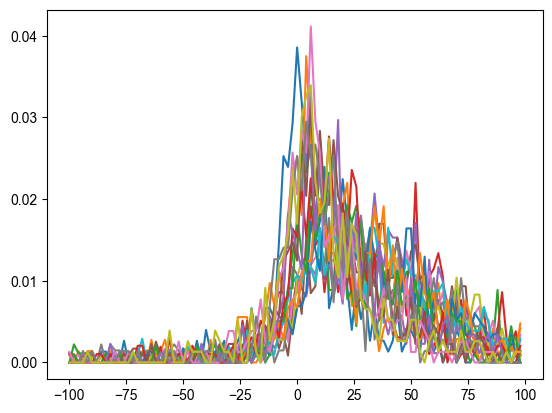

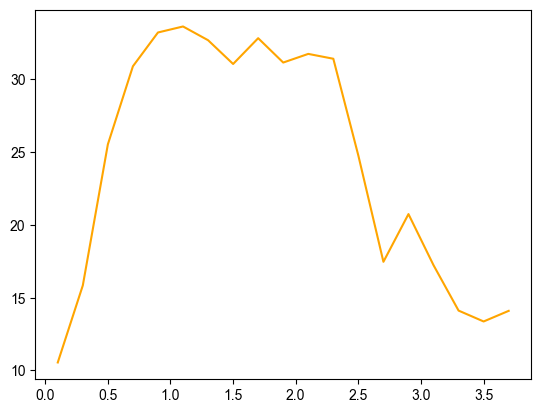

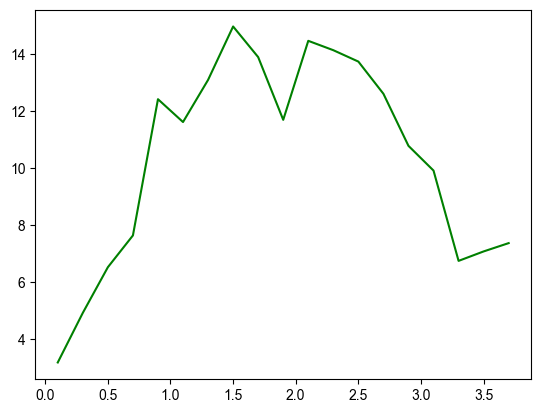

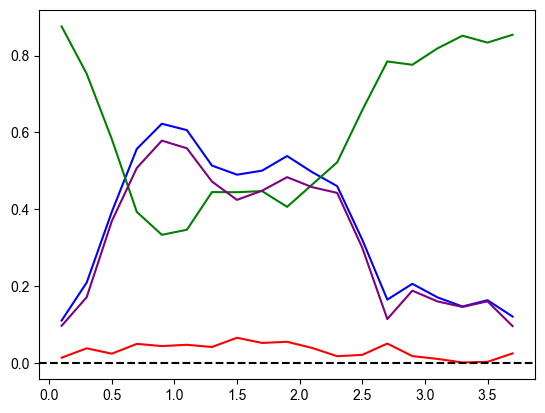

In [4]:

## import the real data of average angle (in blue (zebrafish) and orange (medaka))
## extract one cycle and extract the parameter dynamics of big turn and small turn in each fish

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats


fish_data = []

speciess = ["zebra", "medaka", ]

stimulus_pattern = []

orientations = [0, 1]
patterns = [0,1,2,3,4,5,6,7,8,9]
rests = [0.25, 2]
pulses = [0.25, 0.5, 1, 2, 5]
datafolder = "/Users/yasukoisoe/Dropbox/Yasuko/Project_Harvard/papers/paper_working_memory/data"

exp_names = ["zebra_stimRest", "medaka_stimRest"]
species = ["zebrafish", "medaka"]
fish_colors = ["blue", "orange"]
datas = [pd.read_pickle(r"%s/df_zebra_0dph_group_black_stimRest_pulse.pkl" % datafolder),
         pd.read_pickle(r"%s/df_medaka_0dph_group_black_stimRest_pulse.pkl" % datafolder)]

trial_num = 15
time_start = 7
time_stop = 25
start_timing = 0
middle_timing = time_start
stop_timing = time_stop
dt = 1./ 90
binning1 = np.arange(start_timing, stop_timing-0.1, 0.05)
analysis_bin = np.arange(start_timing, stop_timing-0.1, 0.2)


step=2
x_axis=np.arange(-100, 100, step)

LRs_species, out_fs_species, ave_angles_species = [], [], []
times_species = []
good_stim = 7

for exp_name_i in range(len(exp_names)):
    exp_name = exp_names[exp_name_i]
    good_fishs = []
    fish_color = fish_colors[exp_name_i]
    data = datas[exp_name_i]
    
    for fish_i in range(62):
        if (exp_name_i == 0) & (fish_i == 31):
            pass
        elif (exp_name_i == 0) & (fish_i == 38):
            pass
        else:
            fish_data = data.loc[(data['fish_index'] == fish_i)]

            if fish_data['center_distance'].mean() < 30:
                good_fishs.append(fish_i)
            
    selected_fish_data = data.loc[data['fish_index'].isin(good_fishs)]
    
    i, j = divmod(good_stim, 2)
    pulse = pulses[i]
    rest = rests[j]
    
    stimBinx = np.arange(0, pulse + rest, 0.01)
    unitBinx = np.arange(0, 4, 0.2)
    
    # fish
    stimulus_pattern_n = good_stim 
    r_stim_data = selected_fish_data.loc[(selected_fish_data['stimulus_index'] == stimulus_pattern_n)]

    stimulus_pattern_n = good_stim  + len(patterns)
    l_stim_data = selected_fish_data.loc[(selected_fish_data['stimulus_index'] == stimulus_pattern_n)]

    dfl = l_stim_data.copy()
    dfl['bout_angle'] = l_stim_data['bout_angle']
    
    df = r_stim_data.copy()
    df['bout_angle'] = r_stim_data['bout_angle'] * (-1)

    merge_data = [dfl, df]
    big_data = pd.concat(merge_data)
    
    remainder = big_data.loc[(big_data['start_time_index'] > 7)]
    remainder7 = remainder.copy()
    remainder7['start_time_index'] = remainder['start_time_index'] - 7

    big_data["mode"] = remainder7['start_time_index'].mod(4)
    
    
    big_Amps, small_Amps, norm_small_Amps  = [], [], []
    big_phases, small_phases = [], []
    
    stim_n_i = 7
    
    Als, Ars, Afs, Mfs,Asums, Asums_errors, Mfs_errors, Aves = [], [], [], [], [], [], [],[]

    period_bin_x, period_bin_y, period_bin_x_show = [], [], []
    for t in range(len(unitBinx) - 1):
        period_bin_x.append((unitBinx[t] + unitBinx[t+1])/2)
        
        data_sub = big_data.loc[(big_data["mode"] > unitBinx[t]) & (
                                big_data["mode"] < unitBinx[t + 1]) & (big_data["start_time_index"]>7)]
        
        all_bouts = np.array(data_sub["bout_angle"])
        Aves.append(np.nanmean(all_bouts))
        hist_plot,histbin = np.histogram(all_bouts, range=(-100,100), bins=int(200/2), density=True)
        plt.plot(histbin[:-1], hist_plot)
        sum_val = sum(hist_plot)
        
    
        if exp_name_i == 0: # zebrafish
            Mr, Ml, Sr, Sl = -40.0, 40.0, 20.0, 20.0
            Sf = 6
        else: # medaka
            Mr, Ml, Sr, Sl = -45.0, 45.0, 20.0, 20.0
            Sf = 15

        def three_gaussians(x_axis, *p):
            Al, Ar, Mf = p
            Af = 1- Ar - Al    
            left_turn = np.exp(-(x_axis-Ml)**2/(2.*Sl**2))
            left_turn = left_turn/np.sum(left_turn)
            forward_turn = np.exp(-(x_axis-Mf)**2/(2.*Sf**2))
            forward_turn = forward_turn/np.sum(forward_turn)
            right_turn = np.exp(-(x_axis-Mr)**2/(2.*Sr**2))
            right_turn = right_turn/np.sum(right_turn)
            distribution = (Al * left_turn + Ar * right_turn + Af * forward_turn)*sum_val/(Al + Ar + Af)
            return distribution

        p0=[0.5, 0.1, 0]
        coeff_u, var_matrix = curve_fit(three_gaussians, x_axis, hist_plot, p0=p0, maxfev=5000, 
                                                bounds = ((0.0,0.0, -5,),(0.7,0.7, 15,)))
        
        hist_fit = three_gaussians(x_axis, *coeff_u)
        Al, Ar,  Mf = coeff_u
        Als.append(Al)
        Ars.append(Ar)
        Af = 1 - Al- Ar
        Afs.append(Af)
        Mfs.append(Mf)
        Asums.append(Al-Ar)
    plt.show()
        
    LRs_species.append(Asums)
    out_fs_species.append(Mfs)
    times_species.append(period_bin_x)
    ave_angles_species.append(Aves)

    plt.plot(period_bin_x, Aves, color=fish_color)
    plt.show()
    plt.plot(period_bin_x, Mfs, color="green")
    plt.show()
    plt.plot(period_bin_x, Als, color="blue")
    plt.plot(period_bin_x, Ars, color="red")
    plt.plot(period_bin_x, Afs, color="green")
    plt.plot(period_bin_x, Asums, color="purple")
    plt.axhline(0, linestyle="--", color="black")
    plt.show()

Component-Based Fish Model Fitting
This version fits LRs and out_fs components directly,
then reconstructs average angles for validation.

Usage:
results = run_component_based_analysis(
    ave_times_species,
    LRs_data_species,      # Your measured L-R differences
    out_fs_data_species,   # Your measured small turn data
    ave_angles_species     # Your measured average angles
)
=== COMPONENT-BASED MODEL FITTING ===
Fitting approach: FIT components (LRs, out_fs) → EMERGENT angles
This is more mechanistically sound!

Component-based fitting for zebrafish (Species 0)
Fitting ONLY LRs and out_fs - angles will emerge naturally
Fitting components for species 0...
  Data ranges: LRs=0.61, out_fs=6.28
  Attempt 1: ['0.061', '1.500', '1.255', '0.800', '0.300']
    Success! Loss = 0.516553
  Attempt 2: ['4.318', '3.483', '2.759', '0.732', '0.206']
    Failed: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  Attempt 3: ['1.296', '1.366', '5.894', '0.702', '0.220']
    Failed: CONVERGE

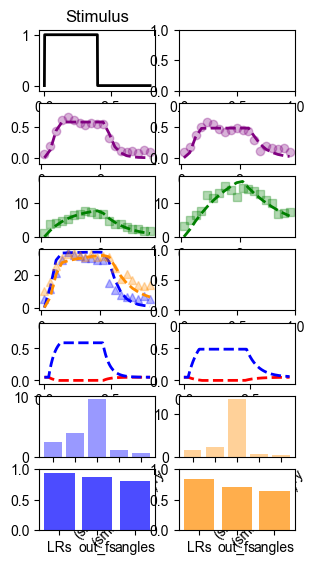

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.optimize import curve_fit, minimize
from scipy import interpolate
import time
import warnings
warnings.filterwarnings('ignore')

# ==== OPTIMIZED CORE FUNCTIONS (SAME AS BEFORE) ====

x_axis = np.arange(-100, 100, 2)

@njit(fastmath=True, cache=True)
def calculate_outputrl_jit_optimized(stimuli, g0, g1, fg0, fg1, RL_boundary, dt, baseline, time_len, delay_time_b, delay_time_s):
    """Optimized version with minimal memory allocation"""
    rs, ls, frs, fls = 0.0, 0.0, 0.0, 0.0
    
    delay_steps_b = int(delay_time_b / dt)
    delay_steps_s = int(delay_time_s / dt)
    
    out_rs = np.empty(time_len)
    out_ls = np.empty(time_len)
    out_fs = np.empty(time_len)
    
    out_rs[0] = baseline
    out_ls[0] = baseline
    out_fs[0] = 0.0
    
    for t in range(time_len-1):
        
        if t >= delay_steps_b:
            stim = stimuli[t - delay_steps_b]  # THIS IS THE KEY: delayed stimulus
        else:
            stim = 0.0  # No stimulus during initial delay period
            
        if stim > 0:
            stim_l = stim * 1.0
            stim_r = stim * (-0.1)
        elif stim < 0:
            stim_l = stim * 0.1
            stim_r = stim * (-1.0)
        else:
            stim_r, stim_l = 0.0, 0.0
            
        if t >= delay_steps_s:
            stim_s = stimuli[t - delay_steps_s]  # THIS IS THE KEY: delayed stimulus
        else:
            stim_s = 0.0  # No stimulus during initial delay period
            
        if stim_s > 0:
            stim_l_s = stim_s * 1.0
            stim_r_s = stim_s * (-0.1)
        elif stim < 0:
            stim_l_s = stim_s * 0.1
            stim_r_s = stim_s * (-1.0)
        else:
            stim_r_s, stim_l_s = 0.0, 0.0
            
        
        rs += (g0 * stim_r - g1 * rs ) * dt
        ls += (g0 * stim_l - g1 * ls) * dt
        frs += (fg0 * stim_r_s - fg1 * frs) * dt
        fls += (fg0 * stim_l_s - fg1 * fls) * dt
        
        if rs + baseline <= 0:
            out_rs[t + 1] = 0
        else:
            out_rs[t + 1] = min(rs + baseline, RL_boundary)
            
        if ls + baseline <= 0:
            out_ls[t + 1] = 0
        else:
            out_ls[t + 1] = min(ls + baseline, RL_boundary)
        
        out_fs[t + 1] = fls - frs
    
    return out_rs, out_ls, out_fs

@njit(fastmath=True, cache=True)
def make_angle_distribution_optimized(out_l, out_r, out_f, x_axis, species):
    """Optimized angle distribution calculation"""
    if species == 0:  # zebrafish
        Mr, Ml, Sr, Sl, Sf = -40.0, 40.0, 20.0, 20.0, 6.0
    else:  # medaka
        Mr, Ml, Sr, Sl, Sf = -45.0, 45.0, 20.0, 20.0, 15.0
    
    Ar, Al = out_r, out_l
    
    Af = max(0.0, 1.0 - Ar - Al)
    
    Mf = out_f
    
    inv_2Sl2 = 1.0 / (2.0 * Sl * Sl)
    inv_2Sr2 = 1.0 / (2.0 * Sr * Sr)
    inv_2Sf2 = 1.0 / (2.0 * Sf * Sf)
    
    left_turn = np.exp(-(x_axis - Ml) ** 2 * inv_2Sl2)
    right_turn = np.exp(-(x_axis - Mr) ** 2 * inv_2Sr2)
    forward_turn = np.exp(-(x_axis - Mf) ** 2 * inv_2Sf2)

    distribution = (Al * left_turn + Ar * right_turn + Af * forward_turn)#/(Al + Ar + Af)
    
    return distribution


@njit(fastmath=True, cache=True)
def simulate_angles_optimized(out_rs, out_ls, out_fs, x_axis, species):
    """Optimized angle simulation"""
    time_len = len(out_rs)
    all_angles = np.empty(time_len)
    
    for t in range(time_len):
        distribution = make_angle_distribution_optimized(out_ls[t], out_rs[t], out_fs[t], x_axis, species)
        
        scale = sum(distribution)
        dsum = []
        for d in range(len(distribution)):
            dsum.append(distribution[d]*x_axis[d]/scale)
        all_angles[t] = sum(dsum)
    
    return all_angles

# ==== CACHED STIMULUS GENERATION ====

class StimulusCache:
    def __init__(self):
        self.cache = {}
    
    def get_stimulus(self, start, period, pattern, time_array):
        key = (start, period, pattern, len(time_array), time_array[0], time_array[-1])
        
        if key not in self.cache:
            self.cache[key] = self._generate_stimulus(time_array, start, period, pattern)
        
        return self.cache[key]
    
    @staticmethod
    @njit(fastmath=True, cache=True)
    def _generate_stimulus(time_array, start, period, pattern):
        stimuli = np.zeros(len(time_array))
        
        if pattern == 0:
            for i, t in enumerate(time_array):
                if t >= start:
                    if np.sin((t - start) * 2 * np.pi / period) > 0:
                        stimuli[i] = 1.0
        elif pattern == 1:
            for i, t in enumerate(time_array):
                if t >= start:
                    stimuli[i] = -np.sin(t * 2 * np.pi / period)
        
        return stimuli

stimulus_cache = StimulusCache()

# ==== NEW: COMPONENT-BASED FITTING FUNCTIONS ====

def calculate_components_optimized(time_x_data, g0, g1, fg0, fg1, RL_boundary, 
                                 species, start=0, period=4, pattern=0, 
                                 dt_sim=0.01, baseline=0.05, delay_time_b=0.2, delay_time_s=0.15):
    """
    Calculate LRs and out_fs components directly
    
    Returns:
    LRs: left - right big turn difference
    out_fs: small turn component (forward)
    avg_angles: reconstructed average angles
    """
    if species == 0:
        delay_time_b, delay_time_s = 0.15, 0
    else:
        delay_time_b, delay_time_s = 0.15, 0.05
    
    # Create simulation time array
    t_start, t_end = time_x_data[0], time_x_data[-1]
    time_x_sim = np.arange(t_start, t_end + dt_sim, dt_sim)
    
    # Get cached stimulus
    stimuli_array = stimulus_cache.get_stimulus(start, period, pattern, time_x_sim)
    
    # Run optimized simulation
    x_axis = np.arange(-100, 100, 2, dtype=np.float64)
    out_rs, out_ls, out_fs = calculate_outputrl_jit_optimized(
        stimuli_array, g0, g1, fg0, fg1, RL_boundary, dt_sim, baseline, len(time_x_sim), delay_time_b, delay_time_s
    )
    
    # Calculate LRs (left - right difference)
    LRs = out_ls - out_rs
    
    # Simulate final angles
    all_angles = simulate_angles_optimized(out_rs, out_ls, out_fs, x_axis, species)
    
    # Interpolate all components to data timepoints
    LRs_interp = np.interp(time_x_data, time_x_sim, LRs)
    out_fs_interp = np.interp(time_x_data, time_x_sim, out_fs)
    angles_interp = np.interp(time_x_data, time_x_sim, all_angles)
    
    return LRs_interp, out_fs_interp, angles_interp

def create_component_objective_function(time_x_data, actual_LRs, actual_out_fs, species):
    """
    Create objective function that ONLY fits LRs and out_fs components
    Average angles emerge naturally from these components
    """
    
    def objective(params):
        g0, g1, fg0, fg1, RL_boundary = params
        
        try:
            predicted_LRs, predicted_out_fs, _ = calculate_components_optimized(
                time_x_data, g0, g1, fg0, fg1, RL_boundary, species
            )
            
            # Only fit the two components - let angles emerge naturally
            LRs_loss = np.mean((actual_LRs - predicted_LRs)**2)
            out_fs_loss = np.mean((actual_out_fs - predicted_out_fs)**2)
            
            # Simple unweighted sum (or could normalize by variance)
            total_loss = LRs_loss + out_fs_loss
            
            return total_loss
            
        except:
            return 1e6  # Large penalty for failed evaluations
    
    return objective

def fit_components_model(time_x_data, actual_LRs, actual_out_fs, species, n_attempts=5):
    """
    Fit model to ONLY LRs and out_fs components
    Average angles are computed as emergent property for validation
    """
    
    print(f"Fitting components for species {species}...")
    
    # Set bounds based on data characteristics
    LRs_range = np.max(actual_LRs) - np.min(actual_LRs)
    out_fs_range = np.max(actual_out_fs) - np.min(actual_out_fs)
    
    print(f"  Data ranges: LRs={LRs_range:.2f}, out_fs={out_fs_range:.2f}")
    
    # Adaptive bounds based on data
    if species == 0:  # zebrafish
        bounds_dict = {
            'g0': (0.1, 5), 'g1': (0.5, 5), 'fg0': (1, 20), 
            'fg1': (0.2, 2), 'RL_boundary': (0.2, 0.6)
        }
    else:  # medaka
        bounds_dict = {
            'g0': (0.1, 5), 'g1': (0.5, 3), 'fg0': (1, 25), 
            'fg1': (0.2, 1.5), 'RL_boundary': (0.2, 0.65)
        }
    
    bounds = [(bounds_dict[key]) for key in ['g0', 'g1', 'fg0', 'fg1', 'RL_boundary']]
    
    # Create objective function that ONLY fits components
    objective = create_component_objective_function(time_x_data, actual_LRs, actual_out_fs, species)
    
    best_result = None
    best_loss = np.inf
    
    # Multiple attempts with different initial conditions
    for attempt in range(n_attempts):
        if attempt == 0:
            # Smart initial guess based on data
            g0_guess = LRs_range / 10
            g1_guess = 1.5
            fg0_guess = out_fs_range / 5
            fg1_guess = 0.8
            boundary_guess = 0.3
            initial_guess = [g0_guess, g1_guess, fg0_guess, fg1_guess, boundary_guess]
        else:
            # Random initial guess within bounds
            initial_guess = [np.random.uniform(b[0], b[1]) for b in bounds]
        
        print(f"  Attempt {attempt + 1}: {[f'{x:.3f}' for x in initial_guess]}")
        
        try:
            result = minimize(
                objective, 
                initial_guess,
                method='L-BFGS-B',
                bounds=bounds,
                options={'maxiter': 2000, 'ftol': 1e-12}
            )
            
            if result.success and result.fun < best_loss:
                best_result = result
                best_loss = result.fun
                print(f"    Success! Loss = {result.fun:.6f}")
            else:
                print(f"    Failed: {result.message if hasattr(result, 'message') else 'Unknown error'}")
                
        except Exception as e:
            print(f"    Exception: {str(e)}")
            continue
    
    if best_result is None:
        print(f"  All fitting attempts failed for species {species}")
        return None, None, None, None
    
    # Get final predictions
    params = best_result.x
    predicted_LRs, predicted_out_fs, emergent_angles = calculate_components_optimized(
        time_x_data, *params, species
    )
    
    # Calculate R-squared for fitted components only
    def calc_r2(actual, predicted):
        ss_res = np.sum((actual - predicted)**2)
        ss_tot = np.sum((actual - np.mean(actual))**2)
        return 1 - (ss_res / ss_tot)
    
    r2_LRs = calc_r2(actual_LRs, predicted_LRs)
    r2_out_fs = calc_r2(actual_out_fs, predicted_out_fs)
    
    print(f"  Final R²: LRs={r2_LRs:.4f}, out_fs={r2_out_fs:.4f}")
    print(f"  (Average angles emerge naturally - not fitted directly)")
    
    return params, (predicted_LRs, predicted_out_fs, emergent_angles), (r2_LRs, r2_out_fs), best_loss

def fit_single_species_components(species_idx, time_data, LRs_data, out_fs_data, 
                                 angles_data, species_name):
    """
    Fit a single species using component-based approach
    Only fits LRs and out_fs - angles emerge naturally
    """
    
    print(f"\n{'='*60}")
    print(f"Component-based fitting for {species_name} (Species {species_idx})")
    print(f"Fitting ONLY LRs and out_fs - angles will emerge naturally")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # Fit only components (no angles)
    params, predictions, r_squares, final_loss = fit_components_model(
        time_data, LRs_data, out_fs_data, species_idx
    )
    
    fitting_time = time.time() - start_time
    
    if params is not None:
        g0, g1, fg0, fg1, RL_boundary = params
        predicted_LRs, predicted_out_fs, emergent_angles = predictions
        r2_LRs, r2_out_fs = r_squares
        
        # Calculate emergent angle quality (for validation only)
        def calc_r2(actual, predicted):
            ss_res = np.sum((actual - predicted)**2)
            ss_tot = np.sum((actual - np.mean(actual))**2)
            return 1 - (ss_res / ss_tot)
        
        r2_emergent_angles = calc_r2(angles_data, emergent_angles)
        
        print(f"\n✓ SUCCESS for {species_name}:")
        print(f"  Input gain (g0): {g0:.3f}")
        print(f"  Decay rate (g1): {g1:.3f}") 
        print(f"  Small turn gain (fg0): {fg0:.3f}")
        print(f"  Small turn decay (fg1): {fg1:.3f}")
        print(f"  Saturation boundary: {RL_boundary:.3f}")
        print(f"  Fitted components R²: LRs={r2_LRs:.4f}, out_fs={r2_out_fs:.4f}")
        print(f"  Emergent angles R²: {r2_emergent_angles:.4f} (not fitted, just emerged)")
        print(f"  Fitting time: {fitting_time:.1f}s")
        
        return {
            'species': species_name,
            'species_idx': species_idx,
            'params': params,
            'predicted_LRs': predicted_LRs,
            'predicted_out_fs': predicted_out_fs,
            'emergent_angles': emergent_angles,
            'r2_LRs': r2_LRs,
            'r2_out_fs': r2_out_fs,
            'r2_emergent_angles': r2_emergent_angles,
            'final_loss': final_loss,
            'fitting_time': fitting_time
        }
    else:
        print(f"\n✗ FAILED for {species_name}")
        return None

def run_component_based_analysis(ave_times_species, LRs_data_species, out_fs_data_species, 
                                ave_angles_species, exp_names=["zebrafish", "medaka"]):
    """
    Run component-based analysis for all species
    Fits ONLY LRs and out_fs - average angles emerge naturally
    
    Parameters:
    ave_times_species: list of time arrays for each species
    LRs_data_species: list of measured LRs (left-right) for each species  
    out_fs_data_species: list of measured out_fs (small turns) for each species
    ave_angles_species: list of measured average angles for each species (for validation only)
    """
    
    print("=== COMPONENT-BASED MODEL FITTING ===")
    print("Fitting approach: FIT components (LRs, out_fs) → EMERGENT angles")
    print("This is more mechanistically sound!")
    
    results = []
    
    for species_idx in range(len(exp_names)):
        result = fit_single_species_components(
            species_idx,
            ave_times_species[species_idx],
            LRs_data_species[species_idx],
            out_fs_data_species[species_idx], 
            ave_angles_species[species_idx],  # Only for validation
            exp_names[species_idx]
        )
        
        if result is not None:
            results.append(result)
    
    if not results:
        print("All fitting attempts failed!")
        return None
    
    # Create visualization
    create_component_plots_small(results, ave_times_species, LRs_data_species, 
                          out_fs_data_species, ave_angles_species)
    
    return results


def create_component_plots_small(results, ave_times_species, LRs_data_species, 
                          out_fs_data_species, ave_angles_species):
    """
    Create comprehensive plots for component-based fitting
    """
    
    fish_colors = ["blue", "darkorange"]
    figure, axes = plt.subplots(7,2, figsize=[3.3,6.5])
    
    # Stimulus plot
    time_x = np.arange(0, 4, 0.01)
    stimuli = stimulus_cache.get_stimulus(0, 4, 0, time_x)
    axes[0, 0].plot(time_x, stimuli, 'k-', linewidth=2)
    axes[0, 0].set_ylim(-0.1, 1.1)
    axes[0, 0].set_title('Stimulus')
    axes[0, 0].set_xlabel('Time (s)')
    
    for result_i, result in enumerate(results):
        species_idx = result['species_idx']
        params = result['params']
        
        actual_x = ave_times_species[species_idx]
        color = fish_colors[species_idx]
        
        # LRs comparison
        axes[1, species_idx].plot(actual_x, LRs_data_species[species_idx], 'o', 
                       color="purple", alpha=0.3, label=f'{result["species"]} data')
        axes[1, species_idx].plot(actual_x, result['predicted_LRs'], '--', 
                       color="purple", linewidth=2, )
        axes[1, species_idx].set_ylim(-0.1,0.9)
        
        # out_fs comparison
        axes[2, species_idx].plot(actual_x, out_fs_data_species[species_idx], 's', 
                       color="green", alpha=0.3, label=f'{result["species"]} data')
        axes[2, species_idx].plot(actual_x, result['predicted_out_fs'], '--', 
                       color="green", linewidth=2,)
        axes[2, species_idx].set_ylim(-0.1,18)
        
        # Average angles comparison (validation)
        axes[3,0].plot(actual_x, ave_angles_species[species_idx], '^', 
                       color=color, alpha=0.3, label=f'{result["species"]} data')
        axes[3,0].plot(actual_x, result['emergent_angles'], '--', 
                       color=color, linewidth=2,)
        
        # Component dynamics
        time_x_full = np.arange(0, 4, 0.01)
        g0, g1, fg0, fg1, RL_boundary = params
        
        if result_i == 0:
            delay_time_b, delay_time_s = 0.15, 0
        else:
            delay_time_b, delay_time_s = 0.15, 0.05
        
        out_rs, out_ls, out_fs = calculate_outputrl_jit_optimized(
            stimulus_cache.get_stimulus(0, 4, 0, time_x_full),
            g0, g1, fg0, fg1, RL_boundary, 0.01, 0.05, len(time_x_full),delay_time_b, delay_time_s
        )
        
        LRs_full = out_ls - out_rs
        
        # Individual components
        axes[4, species_idx].plot(time_x_full, out_rs, 'r--', label='Right', linewidth=2)
        axes[4, species_idx].plot(time_x_full, out_ls, 'b--', label='Left', linewidth=2)
        axes[4, species_idx].set_ylim(-0.05,0.9)
        
        # Parameter comparison
        param_names = ['g0\n(input)', 'g1\n(decay)', 'fg0\n(small_gain)', 'fg1\n(small_decay)', 'boundary']
        axes[5, species_idx].bar(param_names, params, color=color, alpha=0.4)
        axes[5, species_idx].tick_params(axis='x', rotation=45)
        
        # R² comparison
        r2_names = ['LRs', 'out_fs', 'angles']
        r2_values = [result['r2_LRs'], result['r2_out_fs'], result['r2_emergent_angles']]
        axes[6, species_idx].bar(r2_names, r2_values, color=color, alpha=0.7)
        axes[6, species_idx ].set_ylim(0, 1)
    
        plt.tight_layout()
    plt.tight_layout()
    plt.savefig("/Users/yasukoisoe/Dropbox/Yasuko/Project_Harvard/papers/paper_working_memory/data/simulation/simulation_good_delay_250708_transportDelay.svg", # % (species_i, stim_n_i),
                        transparent=True)
    plt.show()

if __name__ == "__main__":
    print("Component-Based Fish Model Fitting")
    print("=" * 50)
    print("This version fits LRs and out_fs components directly,")
    print("then reconstructs average angles for validation.")
    print()
    print("Usage:")
    print("results = run_component_based_analysis(")
    print("    ave_times_species,")
    print("    LRs_data_species,      # Your measured L-R differences") 
    print("    out_fs_data_species,   # Your measured small turn data")
    print("    ave_angles_species     # Your measured average angles")
    print(")")
    
    ave_times_species = times_species 
    LRs_data_species = LRs_species
    out_fs_data_species = out_fs_species
    ave_angles_species = ave_angles_species
    

    # Example with your data structure:
    results = run_component_based_analysis(
        ave_times_species, 
        LRs_data_species, 
        out_fs_data_species,
        ave_angles_species

    )

In [ ]:
## print parameters
    
parameters = [(2.0, 5, 9.624, 1.219, 0.50), (1.609, 2.273, 13.539, 0.610,0.486) ]

In [6]:
## functions for confidence interval of the actual data

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats

def sine_function_fixed_freq(t, amplitude, phase, offset, frequency):
    """Your original function with better type handling"""
    # Ensure all inputs are float type
    t = np.asarray(t, dtype=float)
    amplitude = float(amplitude)
    phase = float(phase) 
    offset = float(offset)
    frequency = float(frequency)
    
    period = 1.0/frequency
    return -amplitude * np.sin(frequency * 2 * np.pi * (t - phase * period / (2 * 360.0))) + offset

def get_fitting_confidence_intervals_fixed(t_data, y_data, stimulus_frequency, confidence_level=0.95):
    """
    Fixed version of your original function with better error handling
    """
    
    # Convert to numpy arrays with proper dtype
    t_data = np.asarray(t_data, dtype=float)
    y_data = np.asarray(y_data, dtype=float)
    stimulus_frequency = float(stimulus_frequency)
    
    # Check for valid inputs
    if len(t_data) < 4:
        print(f"Warning: Only {len(t_data)} data points, need at least 4")
        return None
    
    if np.any(~np.isfinite(t_data)) or np.any(~np.isfinite(y_data)):
        print("Warning: Data contains NaN or infinite values")
        return None
    
    def sine_wrapper(t, amplitude, phase, offset):
        return sine_function_fixed_freq(t, amplitude, phase, offset, stimulus_frequency)
    
    # Better initial guess
    amp_guess = (np.max(y_data) - np.min(y_data)) / 2.0
    offset_guess = np.mean(y_data)
    phase_guess = 0.0
    initial_guess = [amp_guess, phase_guess, offset_guess]
    
    try:
        # Fit with covariance matrix
        fitted_params, covariance = curve_fit(
            sine_wrapper, t_data, y_data, 
            p0=initial_guess,
            maxfev=2000
        )
        
        amplitude_fit, phase_fit, offset_fit = fitted_params
        
        # Wrap phase to 0-360 degrees
        phase_fit = phase_fit % 360.0
        
        # Calculate parameter uncertainties from covariance matrix
        if covariance is not None and np.all(np.isfinite(covariance)):
            param_std_errors = np.sqrt(np.diag(covariance))
            amplitude_std_error = param_std_errors[0]
            phase_std_error = param_std_errors[1]
            offset_std_error = param_std_errors[2]
            
            # Convert to confidence intervals
            alpha = 1 - confidence_level
            dof = len(y_data) - 3  # 3 parameters fitted
            t_value = stats.t.ppf(1 - alpha/2, dof)
            
            amplitude_ci = t_value * amplitude_std_error
            phase_ci = t_value * phase_std_error
            offset_ci = t_value * offset_std_error
            
            # Cap unreasonably large phase CI at 90 degrees
            max_reasonable_phase_ci = 360
            if phase_ci > max_reasonable_phase_ci:
                print(f"Warning: Large phase CI ({phase_ci:.1f}°) capped at {max_reasonable_phase_ci}°")
                phase_ci = max_reasonable_phase_ci
            
        else:
            print("Warning: Could not calculate confidence intervals")
            amplitude_ci = phase_ci = offset_ci = np.inf
            amplitude_std_error = phase_std_error = offset_std_error = np.inf
        
        # Calculate fitting quality metrics
        y_fitted = sine_wrapper(t_data, *fitted_params)
        residuals = y_data - y_fitted
        rmse = np.sqrt(np.mean(residuals**2))
        
        # R-squared
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_data - np.mean(y_data))**2)
        r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
        
        # Reduced chi-squared (goodness of fit)
        dof = len(y_data) - 3
        reduced_chi_squared = ss_res / dof if dof > 0 else np.inf
        
        return {
            # Fitted parameters
            'amplitude': float(amplitude_fit),
            'phase_deg': float(phase_fit),
            'offset': float(offset_fit),
            
            # Confidence intervals (±values)
            'amplitude_ci': float(amplitude_ci),
            'phase_ci_deg': float(phase_ci),
            'offset_ci': float(offset_ci),
            
            # Standard errors
            'amplitude_std_error': float(amplitude_std_error),
            'phase_std_error': float(phase_std_error),
            'offset_std_error': float(offset_std_error),
            
            # Relative uncertainties
            'amplitude_relative_error': float(amplitude_std_error / amplitude_fit) if amplitude_fit != 0 else np.inf,
            'phase_relative_error_deg': float(phase_ci / abs(phase_fit)) if phase_fit != 0 else np.inf,
            
            # Fitting quality
            'rmse': float(rmse),
            'r_squared': float(r_squared),
            'reduced_chi_squared': float(reduced_chi_squared),
            'covariance': covariance,
            'y_fitted': y_fitted,
            'residuals': residuals
        }
        
    except Exception as e:
        print(f"Fitting failed: {str(e)}")
        return None


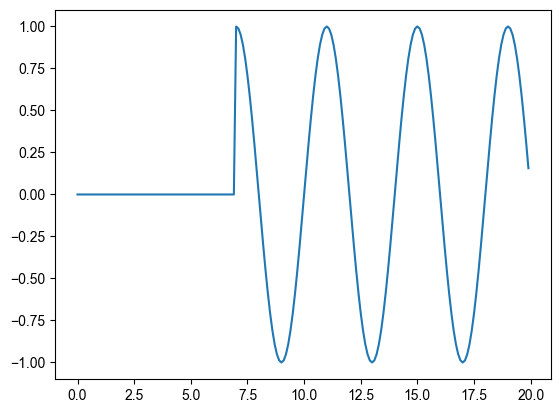

In [16]:
## stimuli curve

def stimuli_function(time_x_axis_2, start, period, pattern):
    stimuli_ = []
    for j in range(len(time_x_axis_2)):
        if time_x_axis_2[j]< start:
            stimuli_.append(0)
        else:
            if pattern == 1:
                signal = -np.sin((time_x_axis_2[j])*2*np.pi/period)
                stimuli_.append(signal)
            else:
                signal = np.sin((time_x_axis_2[j]-start)*2*np.pi/period)
                if signal > 0:
                    signal_real= 1
                else:
                    signal_real = 0
                stimuli_.append(signal_real)
    return stimuli_

time_x_axis_2 = np.arange(0, 25, 0.01)

stimuli_ = stimuli_function(time_x_axis_2=np.arange(0, 20, 0.1), start=7, period=4, pattern=1)
plt.plot(np.arange(0, 20, 0.1),stimuli_)

In [17]:
## run fitting and
## find decent parameters of g0 and g1, fg0, fg1

dt = 0.01
time_x = np.arange(0, 25, dt)
exp_names = ["zebra_stimRest", "medaka_stimRest"]
speciess = ["zebrafish", "medaka"]
baseline = 0.05
fish_colors = ["blue","darkorange",]

red_shades, blue_shades, black_shades = [], [], []

@njit(fastmath=True)
def calculate_outputrl_jit_big_small(stimuli, g0, g1, fg0, fg1, RL_boundary, dt, baseline, time_len, delay_time_b, delay_time_s):

    delay_steps_b = int(delay_time_b / dt)
    delay_steps_s = int(delay_time_s / dt)
    
    rs = np.zeros(time_len)
    ls = np.zeros(time_len)
    frs = np.zeros(time_len)
    fls = np.zeros(time_len)
    
    out_rs = np.zeros(time_len)
    out_ls = np.zeros(time_len)
    out_frs = np.zeros(time_len)
    out_fls = np.zeros(time_len)
    out_fs = np.zeros(time_len)
    
    out_rs[0] = rs[0] + baseline
    out_ls[0] = ls[0] + baseline
    out_frs[0] = rs[0] + baseline
    out_fls[0] = ls[0] + baseline
    

    for t in range(time_len-1):
        
        if t >= delay_steps_b:
            stim = stimuli[t - delay_steps_b]  # THIS IS THE KEY: delayed stimulus
        else:
            stim = 0.0  # No stimulus during initial delay period
            
        if stim > 0:
            stim_l = stim * 1.0
            stim_r = stim * (-0.1)
        elif stim < 0:
            stim_l = stim * 0.1
            stim_r = stim * (-1.0)
        else:
            stim_r, stim_l = 0.0, 0.0
            
        if t >= delay_steps_s:
            stim_s = stimuli[t - delay_steps_s]  # THIS IS THE KEY: delayed stimulus
        else:
            stim_s = 0.0  # No stimulus during initial delay period
            
        if stim_s > 0:
            stim_l_s = stim_s * 1.0
            stim_r_s = stim_s * (-0.1)
        elif stim < 0:
            stim_l_s = stim_s * 0.1
            stim_r_s = stim_s * (-1.0)
        else:
            stim_r_s, stim_l_s = 0.0, 0.0
            

        rs[t+1] = rs[t] + (g0*stim_r - g1*rs[t]) * dt
        ls[t+1] = ls[t] + (g0*stim_l - g1*ls[t]) * dt
        
        frs[t+1] = frs[t] + (fg0*stim_r_s - fg1*frs[t]) * dt
        fls[t+1] = fls[t] + (fg0*stim_l_s - fg1*fls[t]) * dt
        

        out_rs[t+1] = rs[t+1] + baseline
        out_ls[t+1] = ls[t+1] + baseline
        
        if rs[t] + baseline <= 0:
            out_rs[t + 1] = 0
        else:
            out_rs[t + 1] = min(rs[t] + baseline, RL_boundary)
            
        if ls[t] + baseline <= 0:
            out_ls[t + 1] = 0
        else:
            out_ls[t + 1] = min(ls[t] + baseline, RL_boundary)
            
            
        out_fs[t+1] = fls[t+1] - frs[t+1]
    
    return out_rs, out_ls, out_fs

x_axis = np.arange(-100, 100, 2)

@njit(fastmath=True)
def make_angleDistribution_jit_big_small(out_l, out_r, out_f, x_axis, species):
    if species == 0:
        Sf = 6
        Mr, Ml, Sr, Sl = -40.0, 40.0, 20.0, 20.0
    else:
        Mr, Ml, Sr, Sl = -45.0, 45.0, 20.0, 20.0
        Sf = 15
    
    Ar = out_r
    Al = out_l
    Af = 1- Ar - Al
    Mf = out_f ## plot in green

    left_turn = np.exp(-(x_axis-Ml)**2/(2.*Sl**2))
    left_turn = left_turn/np.sum(left_turn)
    forward_turn = np.exp(-(x_axis-Mf)**2/(2.*Sf**2))
    forward_turn = forward_turn/np.sum(forward_turn)
    right_turn = np.exp(-(x_axis-Mr)**2/(2.*Sr**2))
    right_turn = right_turn/np.sum(right_turn)

    distribution = Al * left_turn + Ar * right_turn + Af * forward_turn 
    normalized_distribution = distribution / np.sum(distribution)
    
    return normalized_distribution, Af

from scipy.optimize import curve_fit

@njit(fastmath=True)
def draw_angle_jit(normalized_distribution, x_axis):
    # Calculate weighted average
    average_angle = np.sum(x_axis * normalized_distribution)
    return average_angle

pulse_time = 2
start_time = 7
unitBin_up = np.arange(start_time, start_time+pulse_time,0.01)
mask_up = (time_x >= unitBin_up[0]) & (time_x <= unitBin_up[-1])
ind_up = np.where(mask_up)[0]
unitBin_down = np.arange(start_time+pulse_time, start_time+2*pulse_time,0.01)
mask_down = (time_x >= unitBin_down[0]) & (time_x <= unitBin_down[-1])
ind_down = np.where(mask_down)[0]

def calculate_time_constant_up(ind_up, time_x, aves):
    def up_exp_cureve(x, *p):
        tau, onset, A, t0 = p
        return A *(1 - np.exp(-(x - t0)/tau)) + onset
    p0 = [1, 0.1, 35, 7]
    coeff_u, var_matrix = curve_fit(up_exp_cureve, time_x[ind_up], aves[ind_up], p0=p0, maxfev=5000, bounds = ((0,0,0,7),(20,1,60,7+0.5)))
    out_fit_up = up_exp_cureve(unitBin_up, *coeff_u)
    tau_u = coeff_u[0]
    return tau_u
    
def calculate_time_constant_down(ind_down, time_x, aves):
    def down_exp_cureve(x, *p):
        tau, onset, A, t0 = p
        return A * np.exp(-(x - t0)/tau) + onset
    p0 = [1, 0.1, 35, 7+period]
    coeff_u, var_matrix = curve_fit(down_exp_cureve, time_x[ind_down], aves[ind_down], p0=p0, maxfev=5000, bounds = ((0,0,0,7+period),(90,1,51,7+period+1)))
    out_fit_down = down_exp_cureve(unitBin_down, *coeff_u)
    tau_d = coeff_u[0]
    return tau_d

def calculate_fit_metrics(actual_x, actual_y, sim_x, sim_y):
    # Interpolate simulation data to actual x points
    interp_func = interpolate.interp1d(sim_x, sim_y, kind='linear', 
                                       bounds_error=False, fill_value='extrapolate')
    sim_y_interp = interp_func(actual_x)
    
    # Calculate metrics
    mse = np.mean((actual_y - sim_y_interp)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(actual_y - sim_y_interp))
    
    # R-squared
    ss_res = np.sum((actual_y - sim_y_interp)**2)
    ss_tot = np.sum((actual_y - np.mean(actual_y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    return mse, rmse, r_squared

@njit(fastmath=True)
def simulate_angles_jit_big_small(out_rs, out_ls, out_fs, time_len, x_axis, species):
    # Pre-allocate arrays for results
    all_angles = np.zeros(time_len)
    Afs = np.zeros(time_len)
    for t in range(time_len):
        distribution, Af = make_angleDistribution_jit_big_small(out_ls[t], out_rs[t], out_fs[t], x_axis, species)
        angle = draw_angle_jit(distribution, x_axis)
        all_angles[t] = angle
        Afs[t] = Af
 
    return all_angles, Afs

# Modified main function
def calculate_taus_optimized_big_small(g0, g1, fg0, fg1, RL_boundary, stimuli, time_x, delay_time_b, delay_time_s):
    # Convert inputs to numpy arrays if they aren't already
    stimuli_array = np.array(stimuli, dtype=np.float64)
    time_x_array = np.array(time_x, dtype=np.float64)
    x_axis = np.arange(-100, 100, 2, dtype=np.float64)
    
    # Calculate outputs using JIT function
    out_rs, out_ls, out_fs = calculate_outputrl_jit_big_small(  # Fixed: now matches return values
        stimuli_array, g0, g1, fg0, fg1, RL_boundary, dt, baseline, len(time_x), delay_time_b, delay_time_s
    )
    
    # Simulate angles using JIT function - need to add species parameter
    species = 0  # You may need to pass this as a parameter
    all_angles, Afs = simulate_angles_jit_big_small(out_rs, out_ls, out_fs, len(time_x), x_axis, species)
    aves = all_angles
#     plt.plot(aves)
#     plt.show()
    tau_u = calculate_time_constant_up(ind_up, time_x, aves)
    tau_d = calculate_time_constant_down(ind_down, time_x, aves)

    
    return tau_u, tau_d, aves, out_rs, out_ls, out_fs, Afs

def calculate_outputrl_no_jit_big_small(stimuli, g0, g1, fg0, fg1, RL_boundary, dt, baseline, time_len):
    
    delay_steps_b = int(delay_time_b / dt)
    delay_steps_s = int(delay_time_s / dt)
    
    rs = np.zeros(time_len)
    ls = np.zeros(time_len)
    frs = np.zeros(time_len)
    fls = np.zeros(time_len)
    
    out_rs = np.zeros(time_len)
    out_ls = np.zeros(time_len)
    out_fs = np.zeros(time_len)
    
    out_rs[0] = rs[0] + baseline
    out_ls[0] = ls[0] + baseline
    
    

    for t in range(time_len-1):
        
        if t >= delay_steps_b:
            stim = stimuli[t - delay_steps_b]  # THIS IS THE KEY: delayed stimulus
        else:
            stim = 0.0  # No stimulus during initial delay period
            
        if stim > 0:
            stim_l = stim * 1.0
            stim_r = stim* (-0.1)
        elif stim < 0:
            stim_l = stim * 0.1
            stim_r = stim * (-1.0)
        else:
            stim_r, stim_l = 0.0, 0.0
            
        if t >= delay_steps_s:
            stim_s = stimuli[t - delay_steps_s]  # THIS IS THE KEY: delayed stimulus
        else:
            stim_s = 0.0  # No stimulus during initial delay period
            
        if stim_s > 0:
            stim_l_s = stim_s * 1.0
            stim_r_s = stim_s * (-0.1)
        elif stim < 0:
            stim_l_s = stim_s * 0.1
            stim_r_s = stim_s * (-1.0)
        else:
            stim_r_s, stim_l_s = 0.0, 0.0
            

        rs[t+1] = rs[t] + (g0*stim_r - g1*rs[t]) * dt
        ls[t+1] = ls[t] + (g0*stim_l - g1*ls[t]) * dt
        
        frs[t+1] = frs[t] + (fg0*stim_r_s - fg1*frs[t]) * dt
        fls[t+1] = fls[t] + (fg0*stim_l_s - fg1*fls[t]) * dt
        
        
        out_rs[t+1] = rs[t+1] + baseline
        out_ls[t+1] = ls[t+1] + baseline
        
        if rs[t] + baseline <= 0:
            out_rs[t + 1] = 0
        else:
            out_rs[t + 1] = min(rs[t] + baseline, RL_boundary)
            
        if ls[t] + baseline <= 0:
            out_ls[t + 1] = 0
        else:
            out_ls[t + 1] = min(ls[t] + baseline, RL_boundary)
            
        out_fs[t+1] = fls[t+1] - frs[t+1]
    
    return out_rs, out_ls, out_fs


def make_angleDistribution_no_jit_big_small(out_l, out_r, out_f, x_axis, species):
    if species == 0:
        Sf = 6
        Mr, Ml, Sr, Sl = -40.0, 40.0, 20.0, 20.0
    else:
        Mr, Ml, Sr, Sl = -45.0, 45.0, 20.0, 20.0
        Sf = 15

    Ar = out_r
    Al = out_l
    Af = 1 - Ar - Al
    Mf = out_f

    left_turn = np.exp(-(x_axis-Ml)**2/(2.*Sl**2))
    left_turn = left_turn/np.sum(left_turn)
    forward_turn = np.exp(-(x_axis-Mf)**2/(2.*Sf**2))
    forward_turn = forward_turn/np.sum(forward_turn)
    right_turn = np.exp(-(x_axis-Mr)**2/(2.*Sr**2))
    right_turn = right_turn/np.sum(right_turn)

    distribution = Al * left_turn + Ar * right_turn + Af * forward_turn 
    normalized_distribution = distribution / (Al + Ar + Af)
    return normalized_distribution

def draw_angle_no_jit(normalized_distribution, x_axis):
    # Calculate weighted average
    average_angle = np.sum(x_axis * normalized_distribution)
    return average_angle


def simulate_angles_no_jit_big_small(out_rs, out_ls, out_fs, time_len, x_axis, species):
    all_angles = np.zeros(time_len)
    
    for t in range(time_len):
        distribution = make_angleDistribution_no_jit_big_small(out_ls[t], out_rs[t], out_fs[t], x_axis, species)
        angle = draw_angle_no_jit(distribution, x_axis)
        all_angles[t] = angle
 
    return all_angles

# Fix the time scale mismatch by creating interpolation functions
from scipy import interpolate

def calculate_angles_big_small_wrapper(stimuli_data, dt_sim=0.01):
    def calculate_angles_big_small_inner(time_x_data, *p):
        g0, g1, fg0, fg1, RL_boundary = p
        
        # Create high-resolution time array for simulation
        t_start = time_x_data.min()
        t_end = time_x_data.max()
        time_x_sim = np.arange(t_start, t_end + dt_sim, dt_sim)
        
        ##Create stimulus at simulation resolution
        stim_interp = np.zeros(len(time_x_sim))
        start_time = 7
        period = 4
        
        for i, t in enumerate(time_x_sim):
            if t < start_time:
                stim_interp[i] = 0
            else:
                if np.sin((t-start_time)*np.pi/period) > 0:
                    stim_interp[i] = 1
                else:
                    stim_interp[i] = 0

        stimuli_array = stim_interp
        x_axis = np.arange(-100, 100, 2, dtype=np.float64)
        
        # Run simulation at high resolution
        out_rs, out_ls, out_fs = calculate_outputrl_no_jit_big_small(
            stimuli_array, g0, g1, fg0, fg1, RL_boundary, dt_sim, baseline, len(time_x_sim)
        )
        
        species = 0
        all_angles = simulate_angles_no_jit_big_small(out_rs, out_ls, out_fs, len(time_x_sim), x_axis, species)
        
        # Interpolate to experimental timepoints
        interp_func = interpolate.interp1d(time_x_sim, all_angles, kind='linear', 
                                         bounds_error=False, fill_value='extrapolate')
        aves_interp = interp_func(time_x_data)
        
        return aves_interp
    return calculate_angles_big_small_inner

dt_sim=0.01
time_x_data = ave_times_species[0]
# Create high-resolution time for simulation
t_start = time_x_data.min() if hasattr(time_x_data, 'min') else min(time_x_data)
t_end = time_x_data.max() if hasattr(time_x_data, 'max') else max(time_x_data)
time_x_sim = np.arange(t_start, t_end + dt_sim, dt_sim)

def calculate_angles_big_small(stimuli, time_x_data, *p, dt_sim=0.01):
    g0, g1, fg0, fg1, boundary_low = p
    
    # Recreate stimulus at simulation resolution
    stim_sim = np.zeros(len(time_x_sim))
    start_time = 7
    period = 4
    
    for i, t in enumerate(time_x_sim):
        if t < start_time:
            stim_sim[i] = 0
        else:
            if np.sin((t-start_time)*np.pi/period) > 0:
                stim_sim[i] = 1
            else:
                stim_sim[i] = 0

            
    stimuli_array = stim_sim
    x_axis = np.arange(-100, 100, 2, dtype=np.float64)
    
    # Run simulation
    out_rs, out_ls, out_fs = calculate_outputrl_no_jit_big_small(
        stimuli_array, g0, g1, fg0, fg1, RL_boundary, dt_sim, baseline, len(time_x_sim)
    )
    
    species = 0
    all_angles = simulate_angles_no_jit_big_small(out_rs, out_ls, out_fs, len(time_x_sim), x_axis, species)
    
    # Interpolate to data timepoints
    interp_func = interpolate.interp1d(time_x_sim, all_angles, kind='linear', 
                                     bounds_error=False, fill_value='extrapolate')
    aves_interp = interp_func(time_x_data)
    
    return aves_interp

In [18]:

parameters = [(2.0, 5, 9.624, 1.219, 0.50), (1.609, 2.273, 13.539, 0.610,0.486) ]

0 0 too small
1 12 too big


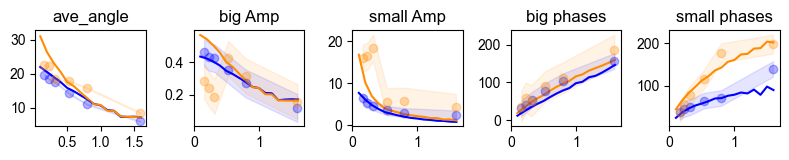

In [19]:
## using the paramaters found with unidirectional stimuli
## run simulation for alternating stimuli
## simulate and calculate the freq_amplitude relationship

frequencies = np.arange(0.1, 1.7, 0.1)
figure2, ax3s = plt.subplots(1,5, figsize=[8, 1.7])
fish_colors = ["blue", "darkorange", "red", "pink"]

delay_timess = [ [0.15, 0.25]]

for delay_time_b_i, delay_times in enumerate(delay_timess):
    delay_time_b, delay_time_sm = delay_times
    
    linestyle_i="-"
        
    for i, (g0, g1, fg0, fg1, RL_boundary) in enumerate(parameters):
        r_squareds, r_squareds_bigonly, r_squareds_sine = [], [], []
        Amp_fit_aves, Amp_fit_bigs, Amp_fit_small_biass, phase_fit_bigs, phase_fit_small_biass,  = [], [], [] , [], []
        g0b, g1b = g0, g1 
        if i == 0:
            delay_time_s = 0
        else:
            delay_time_s = delay_time_sm

        for k in range(len(frequencies)):
            start, period, pattern = 5, 1/(frequencies[k]), 1
            stimuli_ = stimuli_function(time_x_axis_2=time_x_axis_2, start=start, period=period, pattern=pattern)  

            def just_sine_mask(x,*p):
                Amp, onset, phase = p
                return - Amp*np.sin(frequencies[k]*2*np.pi  * (x  - phase*period/(360)))+onset
            frequencie = frequencies[k]

            tau_u, tau_d,aves, out_rs, out_ls, out_fs, Afs = calculate_taus_optimized_big_small(g0, g1, fg0, fg1, RL_boundary,
                                                                                                stimuli_, time_x_axis_2, delay_time_b, delay_time_s )

            period_bin = np.arange(5+0, 5+period+0.2, 0.2)
            period_bin_x, period_bin_y, period_bin_x_show = [], [], []
            for t in range(len(period_bin) - 1):
                period_bin_x.append((period_bin[t] + period_bin[t+1])/2)
                period_bin_y.append(-np.sin(frequencie*2*np.pi*((period_bin[t] + period_bin[t+1])/2)))
            colors = plt.cm.jet_r(np.linspace(0,1,len(period_bin_x)))
            
            mask_x = (time_x_axis_2 >= min(period_bin)) & (time_x_axis_2 <= max(period_bin))
            ind_mask = np.where(mask_x)[0]

            p0 = [20, 5,90] # Pass stimulus data to wrapper
            coeff_u, var_matrix = curve_fit(just_sine_mask, time_x_axis_2[ind_mask], aves[ind_mask], 
                                    p0=p0, maxfev=5000, bounds = ((3,-10,0),(50, 10,360)))
    #         coeff_u, var_matrix = curve_fit(just_sine_mask, time_x_axis_2[ind_mask], aves_small[ind_mask], 
    #                                 p0=p0, maxfev=5000, bounds = ((3,-10,0),(50, 10,180)))
            Amp_fit_ave, onset, phase = coeff_u
            Amp_fit_aves.append(Amp_fit_ave)

            stimuli_amp = []
            for p in range(len(stimuli_)):
                stimuli_amp.append(stimuli_[p]*Amp_fit_ave)

    #         plt.plot(time_x_axis_2, stimuli_amp)
    #         plt.plot(time_x_axis_2, aves,)
    #         plt.show()

            ##### make the freq_amp relationship for big and small turns.
            out_l_rs = []
            for lr in range(len(out_rs)):
                out_l_rs.append(out_ls[lr] - out_rs[lr])

            p0 = [0.5, 0,90] # Pass stimulus data to wrapper
            out_l_rs = np.array(out_l_rs)
            coeff_u, var_matrix = curve_fit(just_sine_mask, time_x_axis_2[ind_mask], out_l_rs[ind_mask], 
                                    p0=p0, maxfev=5000, bounds = ((0,-0.1,0),(1, 0.1, 360)))
            out_l_rs_fit = just_sine_mask(time_x_axis_2[ind_mask], *coeff_u)


            Amp_fit_big, onset, phase = coeff_u
            Amp_fit_bigs.append(Amp_fit_big)
            phase_fit_bigs.append(phase)

            p0 = [20, 0,90] # Pass stimulus data to wrapper
            out_fs = np.array(out_fs)
            coeff_u, var_matrix = curve_fit(just_sine_mask, time_x_axis_2[ind_mask], out_fs[ind_mask], 
                                    p0=p0, maxfev=5000, bounds = ((0,-5,0),(25, 5,360)))
            out_fs_fit = just_sine_mask(time_x_axis_2[ind_mask], *coeff_u)
            Amp_fit_small_bias, onset, phase = coeff_u
            Amp_fit_small_biass.append(Amp_fit_small_bias)
            phase_fit_small_biass.append(phase)
            
            
#             ## make a plot of Asums and Mfs
                
#             figure, axs = plt.subplots(6,1, figsize=[1.5,5])
# #             axs[1].axhline(0, color="grey", linestyle="--", alpha=0.5)
# #             axs[1].plot(period_bin_x_show, Als_show, color="blue", alpha=0.9)
# #     #             axs[1].scatter(period_bin_x, Als,  marker="o", c=colors, s=9)
# #             axs[1].set_xlim(0, period)
# #             axs[1].set_ylim(-0.05, 0.7)
# #     #             axs[1].scatter(period_bin[:-1], Als,  marker="o", c=colors[:-1], s=7)
# #                 axs[1].axhline(0, color="grey", linestyle="--", alpha=0.5)
# #                 axs[1].plot(period_bin_x_show, Ars_show, color="red", alpha=0.9)
# #     #             axs[1].scatter(period_bin_x, Ars,  marker="o", c=colors, s=9)
# #                 axs[1].set_xlim(0, period)
# #                 axs[1].set_ylim(-0.05, 0.9)

#     #             axs[1].scatter(period_bin[:-1], Ars,  marker="o", c=colors[:-1], s=7)
#             axs[3].axhline(0, color="grey", linestyle="--", alpha=0.5)
#             axs[3].plot(time_x_axis_2[ind_mask], out_l_rs[ind_mask], color="purple", linestyle="-")
#             axs[3].plot(time_x_axis_2[ind_mask], out_l_rs_fit, color="pink", linestyle="--")
#     #             axs[3].scatter(period_bin_x, Asums,  marker="o", c=colors, s=9)
#             axs[3].set_xlim(0, period)
#             axs[3].set_ylim(-0.7, 0.7)

# #             axs[4].axhline(0, color="grey", linestyle="--", alpha=0.5)
# #             axs[4].plot(period_bin_x_show, out_fs[ind_mask], color="green", alpha=0.5)
# #     #             axs[4].scatter(period_bin_x, Afs,  marker="o", c=colors, s=9)
# #             axs[4].set_ylim(-0.05,0.8)
# #             axs[4].set_xlim(0, period)


#             axs[5].axhline(0, color="grey", linestyle="--", alpha=0.5)
#             axs[5].plot(time_x_axis_2[ind_mask], out_fs[ind_mask], color="green", linestyle="-", alpha=0.9)
#             axs[5].plot(time_x_axis_2[ind_mask], out_fs_fit, color="yellow", linestyle="--", alpha=0.9)
#     #             axs[5].scatter(period_bin_x, Mfs,  marker="o", c=colors, s=9)
#             axs[5].set_xlim(0, period)
#             axs[5].set_ylim(-30, 30)

#             axs[0].axhline(0, color="grey", linestyle="--", alpha=0.5)
#     #             signals = []
#     #             for j in period_bin:
#     #                 real_period_bin = j+5
#     #                 signal = -np.sin(frequencie*2*np.pi*real_period_bin)
#     #                 signals.append(signal)

#             range_signal_x=np.arange(0,period, 0.01)
#             range_signal_y = -np.sin(frequencie*2*np.pi*(range_signal_x))
#             axs[0].plot(range_signal_x, range_signal_y, color="grey", linewidth=1)
#             axs[0].scatter(period_bin_x, period_bin_y,  marker="o", c=colors, s=9)
#             axs[0].set_xlim(0, period)


#             plt.tight_layout()

#             plt.savefig("/Users/yasukoisoe/Dropbox/Yasuko/Project_Harvard/papers/paper_working_memory/data/alternate_small_big_dynamics_simulation_parameter%s_stim%s_betterXnewColor2_noRainbow_newstd.svg" % (species_i, stim_n_i),
#                             transparent=True)
#             plt.show()

    #         plt.plot(time_x_axis_2[ind_mask], out_l_rs_fit, color="purple")
    #         plt.show()
    #         plt.plot(time_x_axis_2[ind_mask], Afs_fit, color="green")
    #         plt.show()


        ax3s[0].plot(frequencies,Amp_fit_aves,  color=fish_colors[i], linestyle=linestyle_i)#, marker="o",)
        ax3s[0].set_title("ave_angle")

        ax3s[1].plot(frequencies,Amp_fit_bigs, color=fish_colors[i], linestyle=linestyle_i,)# marker="o")
        ax3s[1].set_title("big_proportion")
    #     ax3s[1].set_ylim(0, 0.5)

        ax3s[2].plot(frequencies,Amp_fit_small_biass, color=fish_colors[i], linestyle=linestyle_i,)# marker="o")
        ax3s[2].set_title("small bias")
    #     ax3s[2].set_ylim(0, 20)

        ax3s[3].plot(frequencies,phase_fit_bigs, color=fish_colors[i], linestyle=linestyle_i,)# marker="o")
        ax3s[3].set_title("big_phase")
    #     ax3s[3].set_ylim(0, 185)

        ax3s[4].plot(frequencies,phase_fit_small_biass, color=fish_colors[i], linestyle=linestyle_i,)# marker="o")
        ax3s[4].set_title("small phase")
    #     ax3s[4].set_ylim(0, 185)


import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
import pandas as pd
from scipy.optimize import curve_fit

fish_data = []

speciess = ["zebra", "medaka", ]
fish_frequencies = [[1 / (0.05*2*np.pi), 1 / (0.1*2*np.pi), 1 / (0.2*2*np.pi), 1 / (0.3*2*np.pi), 1 / (0.5*2*np.pi), 1 / (0.7*2*np.pi), 1 / (1.*2*np.pi)], 
                   [1 / (0.1*2*np.pi), 1 / (0.2*2*np.pi), 1 / (0.3*2*np.pi), 1 / (0.5*2*np.pi), 1 / (0.7*2*np.pi), 1 / (1.*2*np.pi), 1 / (1.5*2*np.pi)],
                   ]

patterns = [0,1]
start_time_point = 5
fish_colors = ["blue", "darkorange", "pink"]
time_bin = np.arange(5,25, 0.2)

step = 4
x_axis=np.arange(-100, 100, step)


fish_Eachdata_dict2 = []
good_fishs_list = []


for species_i in range(len(speciess)):
    exp_name = speciess[species_i]
    good_fishs = []
    freq_seq = fish_frequencies[species_i]
    data2 = pd.read_pickle(r"/Users/yasukoisoe/Dropbox/Yasuko/Project_Harvard/papers/paper_working_memory/alternate_data/real_data/df_%s_0dph_group_black_stimRest_sine_pulse_correct.pkl" % (exp_name))
  
    frequencies = fish_frequencies[species_i]
    stimulus_pattern = []            
    for frequencie in frequencies:
        for pattern in patterns:
            stimulus_pattern.append([frequencie, pattern,])
            
    for fish_n in range(35):
        fish_data = data2.loc[(data2['fish_index'] == fish_n)]
        if fish_data['center_distance'].mean() < 35:
            good_fishs.append(fish_n)
            
    good_fishs_list.append(good_fishs)
    ## use only good fish
    
    big_Amps, small_Amps, norm_small_Amps  = [], [], []
    big_phases, small_phases,Ave_Amps, = [], [], []
    freq_seq_show = []
    

    for stim_n_i in range(len(stimulus_pattern)):
        if species_i == 0 and stim_n_i == 0:
            print(species_i, stim_n_i, "too small")
        elif species_i == 1 and stim_n_i == 12:
            print(species_i, stim_n_i, "too big")
        else:
            interest_data = data2.loc[(data2['stimulus_index'] == stim_n_i) & (data2['fish_index'].isin(good_fishs))]

            frequencie5, pattern, = stimulus_pattern[stim_n_i]  

            if pattern == 0:
                frequencie = freq_seq[int(stim_n_i//2)]
                period = 1/frequencie
                freq_seq_show.append(frequencie)

                #time_bin_overlap, mode check
                period_bin = np.arange(0, period+0.2, 0.2)
                Als, Ars, Afs, Mfs,Asums = [], [], [], [], []
                Asums_ci_amps, Mfs_ci_amps, Asums_ci_phases, Mfs_ci_phases, Aves_ci_amps = [], [], [], [], []

                ## make distribution figure for whole one cycle 
    #             figure0, ax0s = plt.subplots(1,2, figsize=[4.5,2])


                period_bin_x, period_bin_y, period_bin_x_show = [], [], []
                for t in range(len(period_bin) - 1):
                    period_bin_x.append((period_bin[t] + period_bin[t+1])/2)
                    period_bin_y.append(-np.sin(frequencie*2*np.pi*((period_bin[t] + period_bin[t+1])/2)))
                colors = plt.cm.jet_r(np.linspace(0,1,len(period_bin_x)))

                period_bin_x_show.append(period_bin_x[0]-0.2)
                period_bin_x_show.extend(period_bin_x)
                
                real_ave=[]

                for t in range(len(period_bin) - 1):
    #                 print("species:%s, stim_n_i:%s, t:%s" % (species_i, stim_n_i, t))
    #                 figure0, ax0s = plt.subplots(1,2, figsize=[3,1.5])

                    interest_data2 = interest_data.loc[(interest_data["start_time_index"] % period > (period_bin[t]))
                                 & (interest_data["start_time_index"] % period  < (period_bin[t+1])) 
                                                       & (interest_data["start_time_index"]>5) ]
                    all_bouts = np.array(interest_data2["bout_angle"])
                    real_ave.append(np.nanmean(all_bouts))
                    hist_plot,_ = np.histogram(all_bouts, range=(-100,100), bins=int(200/step), density=True)

                    ### fit with three gaussians

                    if species_i == 0:
                        Mr, Ml, Sr, Sl = -40.0, 40.0, 20.0, 20.0
                        Sf = 6
                    else:
                        Mr, Ml, Sr, Sl = -45.0, 45.0, 20.0, 20.0
                        Sf = 15

                    def three_gaussians(x_axis, *p):
                        Al, Ar, Mf, constant = p
                        Af = 1- Ar - Al    
                        left_turn = np.exp(-(x_axis-Ml)**2/(2.*Sl**2))
                        left_turn = left_turn/np.sum(left_turn)
                        forward_turn = np.exp(-(x_axis-Mf)**2/(2.*Sf**2))
                        forward_turn = forward_turn/np.sum(forward_turn)
                        right_turn = np.exp(-(x_axis-Mr)**2/(2.*Sr**2))
                        right_turn = right_turn/np.sum(right_turn)


                        distribution = (Al * left_turn + Ar * right_turn + Af * forward_turn)* constant
    #                     normalized_distribution = distribution / np.sum(distribution)

                        return distribution

                    p0=[0.1, 0.1, 0, 1]
                    coeff_u, var_matrix = curve_fit(three_gaussians, x_axis, hist_plot, p0=p0, maxfev=5000, 
                                                    bounds = ((0,0,-40, 0),(0.9,0.9,40,2)))
                    hist_fit = three_gaussians(x_axis, *coeff_u)
                    Al, Ar,  Mf, constant = coeff_u
    #                 print(constant)
                    Als.append(Al)
                    Ars.append(Ar)
                    Af = 1 - Al- Ar
                    Afs.append(Af)
                    Mfs.append(Mf)
                    Asums.append(Al-Ar)
                
                
                ##  now fit the curve with sine wave and extract the time constant
                def sine_wave(times, *p):
                    Amp, phase, onset = p
                    return - Amp*np.sin(frequencie*2*np.pi  * (times  - phase*period/360))+onset
                # ave angles
                p0 = [30, 0, -0.1]
                coeff_u, var_matrix = curve_fit(sine_wave, period_bin_x, real_ave, p0=p0, maxfev=5000, 
                                                    bounds = ((0,0,-0.5),(50,360,0.5)))
                Aves_fit = sine_wave(period_bin_x, *coeff_u)
                Ave_Amp, Ave_phase, Ave_onset = coeff_u
                Ave_Amps.append(Ave_Amp)
                
                # big turns
                p0 = [0.3, 0, -0.1]
                coeff_u, var_matrix = curve_fit(sine_wave, period_bin_x, Asums, p0=p0, maxfev=5000, 
                                                    bounds = ((0,0,-0.5),(1,360,0.5)))
                Asums_fit = sine_wave(period_bin_x, *coeff_u)
                big_Amp, big_phase, big_onset = coeff_u
                big_Amps.append(big_Amp)
                big_phases.append(big_phase)

                # small turns
                if species_i == 0:
                    p0 = [5, 45, -1]
                else:
                    p0 = [20, 45, -5]
                coeff_u, var_matrix = curve_fit(sine_wave, period_bin_x, Mfs, p0=p0, maxfev=5000, 
                                                    bounds = ((0,0,-10),(30,360,10)))
                Mfs_fit = sine_wave(period_bin_x, *coeff_u)
                small_Amp, small_phase, small_onset = coeff_u
                small_Amps.append(small_Amp)
                small_phases.append(small_phase)

                Mfs_show, Mfs_fit_show, Als_show, Ars_show, Asums_show, Asums_fit_show, Afs_show, Aves_show, = [],[],[],[],[],[],[],[]
                Mfs_show.append(Mfs[-1])
                Mfs_show.extend(Mfs)
                Mfs_fit_show.append(Mfs_fit[-1])
                Mfs_fit_show.extend(Mfs_fit)
                Als_show.append(Als[-1])
                Als_show.extend(Als)
                Ars_show.append(Ars[-1])
                Ars_show.extend(Ars)
                Asums_show.append(Asums[-1])
                Asums_show.extend(Asums)
                
                Aves_show.append(Aves_fit[-1])
                Aves_show.extend(Aves_fit)
                
                Asums_fit_show.append(Asums_fit[-1])
                Asums_fit_show.extend(Asums_fit)
                Afs_show.append(Afs[-1])
                Afs_show.extend(Afs)
                
                Aves_ci = get_fitting_confidence_intervals_fixed(t_data=period_bin_x_show, y_data=Aves_show, 
                                                     stimulus_frequency=frequencie, confidence_level=0.95)
                Aves_ci_amp = Aves_ci["amplitude_ci"]
                Aves_ci_amps.append(Aves_ci_amp)
               

                Asums_ci = get_fitting_confidence_intervals_fixed(t_data=period_bin_x_show, y_data=Asums_show, 
                                                     stimulus_frequency=frequencie, confidence_level=0.95)
                Asums_ci_amp = Asums_ci["amplitude_ci"]
                Asums_ci_phase = Asums_ci["phase_ci_deg"]
                Asums_ci_amps.append(Asums_ci_amp)
                Asums_ci_phases.append(Asums_ci_phase)

                Mfs_ci = get_fitting_confidence_intervals_fixed(t_data=period_bin_x_show, y_data=Mfs_show, 
                                                     stimulus_frequency=frequencie, confidence_level=0.95)

                Mfs_ci_amp = Mfs_ci["amplitude_ci"]
                Mfs_ci_phase = Mfs_ci["phase_ci_deg"]
                Mfs_ci_amps.append(Mfs_ci_amp)
                Mfs_ci_phases.append(Mfs_ci_phase)
                
    freq_seq = [1 / (0.1*2*np.pi), 1 / (0.2*2*np.pi), 1 / (0.3*2*np.pi), 1 / (0.5*2*np.pi), 1 / (0.7*2*np.pi), 1 / (1.*2*np.pi),]
            
    for l in range(len(freq_seq)):
        norm_small_Amps.append(small_Amps[l]/max(small_Amps)) 
    ax3s[0].fill_between(freq_seq_show, np.array(Ave_Amps) - np.array(Aves_ci_amps),
                         np.array(Ave_Amps) + np.array(Aves_ci_amps),color=fish_colors[species_i], alpha=0.1)
    ax3s[0].plot(freq_seq_show, Ave_Amps,  marker='o', color=fish_colors[species_i], alpha=0.3, linestyle=" ")
    
    ax3s[1].fill_between(freq_seq_show, np.array(big_Amps) - np.array(Asums_ci_amps),
                         np.array(big_Amps) + np.array(Asums_ci_amps),color=fish_colors[species_i], alpha=0.1)
    ax3s[1].plot(freq_seq, big_Amps,  marker='o', color=fish_colors[species_i], alpha=0.3, linestyle=" ")
    ax3s[1].set_title("big Amp")
    ax3s[1].set_xlim(0, 1.7)
#     ax3s[1].set_ylim(0, 0.5)
    ax3s[2].fill_between(freq_seq_show, np.array(small_Amps) - np.array(Mfs_ci_amps),
                         np.array(small_Amps) + np.array(Mfs_ci_amps),color=fish_colors[species_i], alpha=0.1)
    ax3s[2].plot(freq_seq, small_Amps,  marker='o', color=fish_colors[species_i], alpha=0.3, linestyle=" ")
    ax3s[2].set_title("small Amp")
    ax3s[2].set_xlim(0, 1.7)
#     ax3s[2].set_ylim(0, 20)
    ax3s[3].fill_between(freq_seq_show, np.array(big_phases) - np.array(Asums_ci_phases),
                         np.array(big_phases) + np.array(Asums_ci_phases),color=fish_colors[species_i], alpha=0.1)
    ax3s[3].plot(freq_seq, big_phases,  marker='o', color=fish_colors[species_i], alpha=0.3, linestyle=" ")
    ax3s[3].set_title("big phases")
    ax3s[3].set_xlim(0, 1.7)
#     ax3s[3].set_ylim(0, 185)
    ax3s[4].fill_between(freq_seq_show, np.array(small_phases) - np.array(Mfs_ci_phases),
                         np.array(small_phases) + np.array(Mfs_ci_phases),color=fish_colors[species_i], alpha=0.1)
    ax3s[4].plot(freq_seq, small_phases,  marker='o', color=fish_colors[species_i], alpha=0.3, linestyle=" ", )
    ax3s[4].set_title("small phases")
    ax3s[4].set_xlim(0, 1.7)
#     ax3s[4].set_ylim(0, 185)
        
        
plt.tight_layout()
savefolder = "/Users/yasukoisoe/Dropbox/Yasuko/Project_Harvard/papers/paper_working_memory/data/simulation"
plt.savefig("%s/simulation_euler_250708_freq_amp_many_freq_transport_delay_onlybest_250809.svg" % (savefolder))
plt.show()


species: 0
stim: 0


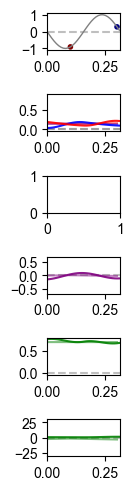

stim: 1
stim: 2


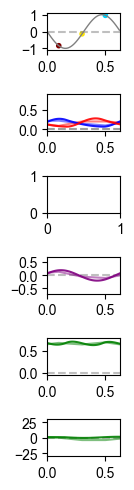

stim: 3
stim: 4


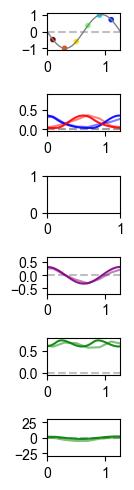

stim: 5
stim: 6


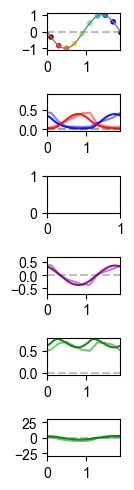

stim: 7
stim: 8


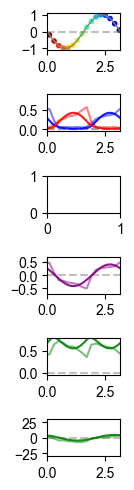

stim: 9
stim: 10


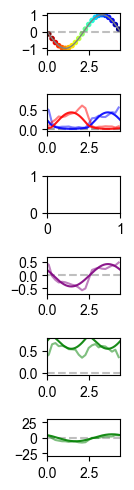

stim: 11
stim: 12


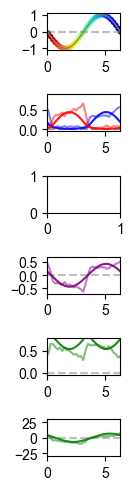

stim: 13
species: 1
stim: 0


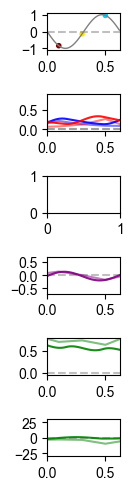

stim: 1
stim: 2


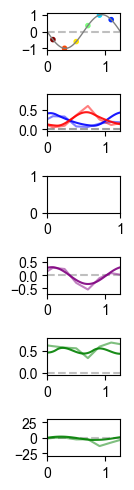

stim: 3
stim: 4


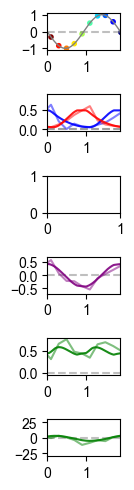

stim: 5
stim: 6


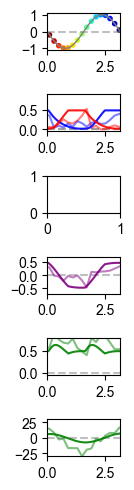

stim: 7
stim: 8


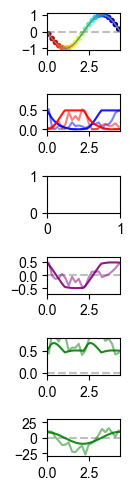

stim: 9
stim: 10


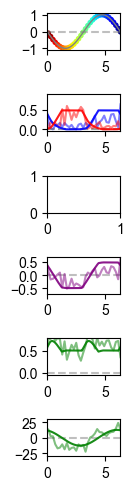

stim: 11
stim: 12


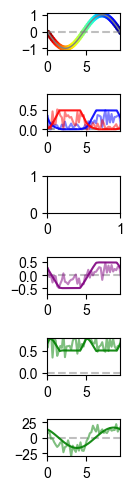

stim: 13


In [20]:
## show one cycle, different columns is different frequency, 
## top row: stimuli
## second row: big turn (left - right)
## third row: small turn
## botoom row: average angle

## left 6 is zebrafish
## right 6  is medaka
    
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats


fish_data = []

speciess = ["zebra", "medaka", ]
fish_frequencies = [[1 / (0.05*2*np.pi), 1 / (0.1*2*np.pi), 1 / (0.2*2*np.pi), 1 / (0.3*2*np.pi), 1 / (0.5*2*np.pi), 1 / (0.7*2*np.pi), 1 / (1.*2*np.pi)], 
                   [1 / (0.1*2*np.pi), 1 / (0.2*2*np.pi), 1 / (0.3*2*np.pi), 1 / (0.5*2*np.pi), 1 / (0.7*2*np.pi), 1 / (1.*2*np.pi), 1 / (1.5*2*np.pi)],
                   ]

patterns = [0,1]
start_time_point = 5
fish_colors = ["blue", "darkorange", "pink"]
time_bin = np.arange(5,25, 0.2)

step = 4
x_axis=np.arange(-100, 100, step)

fish_Eachdata_dict2 = []
good_fishs_list = []

delay_times = [0.15, 0.25]
delay_time_b, delay_time_sm = delay_times

for species_i in range(len(speciess)):
    print("species:", species_i )
    if species_i == 0:
        delay_time_s = 0
    else:
        delay_time_s = delay_time_sm
    g0, g1, fg0, fg1, RL_boundary = parameters[species_i]
    
    exp_name = speciess[species_i]
    good_fishs = []
    freq_seq = fish_frequencies[species_i]
    if species_i < 2:
        data2 = pd.read_pickle(r"/Users/yasukoisoe/Dropbox/Yasuko/Project_Harvard/papers/paper_working_memory/alternate_data/real_data/df_%s_0dph_group_black_stimRest_sine_pulse_correct.pkl" % (exp_name))
    else:
        data2 = pd.read_pickle(r"/Users/yasukoisoe/Dropbox/Yasuko/Project_Harvard/papers/paper_working_memory/alternate_data/real_data/df_df_%s_black_stimRest_sine_pulse_correct_alternate.pkl" % (exp_name))
     
    for fish_n in range(35):
        fish_data = data2.loc[(data2['fish_index'] == fish_n)]
        if fish_data['center_distance'].mean() < 35:
            good_fishs.append(fish_n)
            
    good_fishs_list.append(good_fishs)
    
    big_Amps, small_Amps, norm_small_Amps  = [], [], []
    big_phases, small_phases = [], []
    
    for stim_n_i in range(len(stimulus_pattern)):
        print("stim:", stim_n_i)
        
        interest_data = data2.loc[(data2['stimulus_index'] == stim_n_i) & (data2['fish_index'].isin(good_fishs))]
        
        frequencie5, pattern, = stimulus_pattern[stim_n_i]
        
        
        if pattern == 0:
            frequencie = freq_seq[int(stim_n_i//2)]
            period = 1/frequencie
            
            ####### simulation
            start, period, pattern = 5, 1/(frequencie), 1
            stimuli_ = stimuli_function(time_x_axis_2=time_x_axis_2, start=start, period=period, pattern=pattern)  
            stimuli_ = stimuli_function(time_x_axis_2=time_x_axis_2, start=0, period=period, pattern=pattern)  

            tau_u, tau_d,aves_sim, out_rs_sim, out_ls_sim, out_fs_sim, Afs_sim = calculate_taus_optimized_big_small(g0, g1, fg0, fg1, RL_boundary,
                                                                                                stimuli_, time_x_axis_2, delay_time_b, delay_time_s )
            out_l_rs_sim = []
            for lr in range(len(out_rs_sim)):
                out_l_rs_sim.append(out_ls_sim[lr] - out_rs_sim[lr])
            out_l_rs_sim = np.array(out_l_rs_sim)
            period_bin = np.arange(5+0, 5+period+0.01, 0.01)
            period_bin = np.arange(0+period, period+period+0.01, 0.01)
            period_bin_x, period_bin_y, period_bin_x_show = [], [], []
            for t in range(len(period_bin) - 1):
                period_bin_x.append((period_bin[t] + period_bin[t+1])/2)
                period_bin_y.append(-np.sin(frequencie*2*np.pi*((period_bin[t] + period_bin[t+1])/2)))
            colors = plt.cm.jet_r(np.linspace(0,1,len(period_bin_x)))
            
            mask_x = (time_x_axis_2 >= min(period_bin)) & (time_x_axis_2 <= max(period_bin))
            ind_mask = np.where(mask_x)[0]
            period_bin_x_show_sim = np.arange(0, period, 0.01)
            
            
            ########### real data
            period = 1/frequencie
        
            #time_bin_overlap, mode check
            period_bin = np.arange(0, period+0.2, 0.2)
            Als, Ars, Afs, Mfs,Asums, Asums_errors, Mfs_errors = [], [], [], [], [], [], []
            
            ## make distribution figure for whole one cycle 
#             figure0, ax0s = plt.subplots(1,2, figsize=[4.5,2])
            
            
            period_bin_x, period_bin_y, period_bin_x_show = [], [], []
            for t in range(len(period_bin) - 1):
                period_bin_x.append((period_bin[t] + period_bin[t+1])/2)
                period_bin_y.append(-np.sin(frequencie*2*np.pi*((period_bin[t] + period_bin[t+1])/2)))
            colors = plt.cm.jet_r(np.linspace(0,1,len(period_bin_x)))
            
            period_bin_x_show.append(period_bin_x[0]-0.2)
            period_bin_x_show.extend(period_bin_x)
            
            for t in range(len(period_bin) - 1):
#                 print("species:%s, stim_n_i:%s, t:%s" % (species_i, stim_n_i, t))
#                 figure0, ax0s = plt.subplots(1,2, figsize=[3,1.5])
                
                interest_data2 = interest_data.loc[(interest_data["start_time_index"] % period > (period_bin[t]))
                             & (interest_data["start_time_index"] % period  < (period_bin[t+1])) 
                                                   & (interest_data["start_time_index"]>5) ]
                all_bouts = np.array(interest_data2["bout_angle"])
                hist_plot,_ = np.histogram(all_bouts, range=(-100,100), bins=int(200/step), density=True)
            
                ### fit with three gaussians
    
                if species_i == 0:
                    Mr, Ml, Sr, Sl = -40.0, 40.0, 20.0, 20.0
                    Sf = 6
                else:
                    Mr, Ml, Sr, Sl = -45.0, 45.0, 20.0, 20.0
                    Sf = 15

                def three_gaussians(x_axis, *p):
                    Al, Ar, Mf, constant = p
                    Af = 1- Ar - Al    
                    left_turn = np.exp(-(x_axis-Ml)**2/(2.*Sl**2))
                    left_turn = left_turn/np.sum(left_turn)
                    forward_turn = np.exp(-(x_axis-Mf)**2/(2.*Sf**2))
                    forward_turn = forward_turn/np.sum(forward_turn)
                    right_turn = np.exp(-(x_axis-Mr)**2/(2.*Sr**2))
                    right_turn = right_turn/np.sum(right_turn)
                

                    distribution = (Al * left_turn + Ar * right_turn + Af * forward_turn)* constant
                    return distribution

                p0=[0.1, 0.1, 0, 1]
                coeff_u, var_matrix = curve_fit(three_gaussians, x_axis, hist_plot, p0=p0, maxfev=5000, 
                                                bounds = ((0,0,-30, 0),(0.9,0.9,30,2)))
                hist_fit = three_gaussians(x_axis, *coeff_u)
                Al, Ar,  Mf, constant = coeff_u
                Als.append(Al)
                Ars.append(Ar)
                Af = 1 - Al- Ar
                Afs.append(Af)
                Mfs.append(Mf)
                Asums.append(Al-Ar)

            
            ##  now fit the curve with sine wave and extract the time constant
#             def sine_wave(times, *p):
#                 Amp, phase, onset = p
#                 return -Amp*np.sin(frequencie*2*np.pi  * (times  - phase*period/360))+onset
            
                
#             # big turns
#             p0 = [0.3, 45, -0.1]
#             coeff_u, var_matrix = curve_fit(sine_wave, period_bin_x, Asums, p0=p0, maxfev=5000, 
#                                                 bounds = ((0,0,-0.5),(1,180,0.5)))
#             Asums_fit = sine_wave(period_bin_x, *coeff_u)
#             Asum_error = calculate_amplitude_normalized_metrics(y_actual=Asums, y_fitted=Asums_fit, fitted_params=coeff_u)
#             Asums_errors.append(Asum_error)
#             big_Amp, big_phase, big_onset = coeff_u
#             big_Amps.append(big_Amp)
#             big_phases.append(big_phase)
        
#             # small turns
#             if species_i == 0:
#                 p0 = [5, 45, -1]
#             else:
#                 p0 = [20, 45, -5]
#             coeff_u, var_matrix = curve_fit(sine_wave, period_bin_x, Mfs, p0=p0, maxfev=5000, 
#                                                 bounds = ((0,0,-10),(30,180,10)))
#             Mfs_fit = sine_wave(period_bin_x, *coeff_u)
#             Mfs_error = calculate_amplitude_normalized_metrics(y_actual=Mfs, y_fitted=Mfs_fit, fitted_params=coeff_u)
#             Mfs_errors.append(Mfs_error)
#             small_Amp, small_phase, small_onset = coeff_u
#             small_Amps.append(small_Amp)
#             small_phases.append(small_phase)
            
            Mfs_show, Mfs_fit_show, Als_show, Ars_show, Asums_show, Asums_fit_show, Afs_show = [],[],[],[],[],[],[],
            Mfs_show.append(Mfs[-1])
            Mfs_show.extend(Mfs)
#             Mfs_fit_show.append(Mfs_fit[-1])
#             Mfs_fit_show.extend(Mfs_fit)
            Als_show.append(Als[-1])
            Als_show.extend(Als)
            Ars_show.append(Ars[-1])
            Ars_show.extend(Ars)
            Asums_show.append(Asums[-1])
            Asums_show.extend(Asums)
#             Asums_fit_show.append(Asums_fit[-1])
#             Asums_fit_show.extend(Asums_fit)
            Afs_show.append(Afs[-1])
            Afs_show.extend(Afs)
    
            figure, axs = plt.subplots(6,1, figsize=[1.5,5])
            axs[1].axhline(0, color="grey", linestyle="--", alpha=0.5)
            axs[1].plot(period_bin_x_show, Als_show, color="blue", alpha=0.5)
#             axs[1].scatter(period_bin_x, Als,  marker="o", c=colors, s=9)
            axs[1].set_xlim(0, period)
            axs[1].set_ylim(-0.05, 0.7)
#             axs[1].scatter(period_bin[:-1], Als,  marker="o", c=colors[:-1], s=7)
            axs[1].axhline(0, color="grey", linestyle="--", alpha=0.5)
            axs[1].plot(period_bin_x_show, Ars_show, color="red", alpha=0.5)
#             axs[1].scatter(period_bin_x, Ars,  marker="o", c=colors, s=9)
            axs[1].set_xlim(0, period)
            axs[1].set_ylim(-0.05, 0.9)
            
#             axs[1].scatter(period_bin[:-1], Ars,  marker="o", c=colors[:-1], s=7)
            axs[3].axhline(0, color="grey", linestyle="--", alpha=0.5)
            axs[3].plot(period_bin_x_show, Asums_show, color="purple", linestyle="-", alpha=0.5)
#             axs[3].plot(period_bin_x_show, Asums_fit_show, color="pink", linestyle="--")
#             axs[3].scatter(period_bin_x, Asums,  marker="o", c=colors, s=9)
            axs[3].set_xlim(0, period)
            axs[3].set_ylim(-0.7, 0.7)
            
            axs[4].axhline(0, color="grey", linestyle="--", alpha=0.5)
            axs[4].plot(period_bin_x_show, Afs_show, color="green", alpha=0.5)
#             axs[4].scatter(period_bin_x, Afs,  marker="o", c=colors, s=9)
            axs[4].set_ylim(-0.05,0.8)
            axs[4].set_xlim(0, period)
            
            
            axs[5].axhline(0, color="grey", linestyle="--", alpha=0.5)
            axs[5].plot(period_bin_x_show, Mfs_show, color="green", linestyle="-", alpha=0.5)
#             axs[5].plot(period_bin_x_show, Mfs_fit_show, color="yellow", linestyle="--", alpha=0.9)
#             axs[5].scatter(period_bin_x, Mfs,  marker="o", c=colors, s=9)
            axs[5].set_xlim(0, period)
            axs[5].set_ylim(-30, 30)
        
            axs[1].plot(period_bin_x_show_sim, out_ls_sim[ind_mask], color="blue", alpha=0.9, linestyle="-")
            axs[1].plot(period_bin_x_show_sim, out_rs_sim[ind_mask], color="red", alpha=0.9, linestyle="-")
            axs[3].plot(period_bin_x_show_sim, out_l_rs_sim[ind_mask], color="purple", alpha=0.9, linestyle="-")
            axs[5].plot(period_bin_x_show_sim, out_fs_sim[ind_mask], color="green", alpha=0.9, linestyle="-")
            axs[4].plot(period_bin_x_show_sim, Afs_sim[ind_mask], color="green", alpha=0.9, linestyle="-")
            
            axs[0].axhline(0, color="grey", linestyle="--", alpha=0.5)

            range_signal_x=np.arange(0,period, 0.01)
            range_signal_y = -np.sin(frequencie*2*np.pi*(range_signal_x))
            axs[0].plot(range_signal_x, range_signal_y, color="grey", linewidth=1)
            axs[0].scatter(period_bin_x, period_bin_y,  marker="o", c=colors, s=9)
            axs[0].set_xlim(0, period)
            
        
        
            plt.tight_layout()
        
            plt.savefig("/Users/yasukoisoe/Dropbox/Yasuko/Project_Harvard/papers/paper_working_memory/data/simulation/alternate_small_big_dynamics_fish%s_stim%s_betterXnewColor2_noRainbow_newstd_simulation2.svg" % (species_i, stim_n_i),
                        transparent=True)
            plt.show()